In [1]:
import numpy as np
import random
import time
import os


In [2]:
def generate_random_track(width, height):
    track = np.full((height, width), ' ')
    # Define track borders
    track[0, :] = '#'
    track[-1, :] = '#'
    track[:, 0] = '#'
    track[:, -1] = '#'
    
    # Random obstacles or walls inside the track
    num_obstacles = int(width * height * 0.1)  # 10% of the grid
    for _ in range(num_obstacles):
        x = random.randint(1, width - 2)
        y = random.randint(1, height - 2)
        if track[y, x] == ' ':
            track[y, x] = '#'
    
    # Define start and finish positions
    start_x = random.randint(1, width - 2)
    track[-2, start_x] = 'S'  # Start position at bottom row
    finish_x = random.randint(1, width - 2)
    track[1, finish_x] = 'F'  # Finish position at top row
    
    return track, (start_x, height - 2), (finish_x, 1)


In [3]:
width, height = 50, 20
track, start_pos, finish_pos = generate_random_track(width, height)

def display_track(track):
    for row in track:
        print(''.join(row))
        
display_track(track)
print(f"Start Position: {start_pos}")
print(f"Finish Position: {finish_pos}")


##################################################
#  # #           #                       F   #   #
###  #      #   #       #  #          #          #
#   #    #    # #        #           #   #       #
#              #             #         #   #     #
#    ##     #       #  #        ##            #  #
# #    #  #       #            # # ##            #
#       ###        #  #                          #
#         #   #    #   #                         #
#  #   #           #                             #
#                 #         #                    #
#             #                           #    # #
# #      #  #           #  ##   #    #         # #
#                       # #                  #  ##
#        ##   #                   #              #
#            # #                  #         #    #
#               #    #         #      #          #
#                        #     #        # # #    #
#        S  # #   # #     #      #    # #    #   #
###############################

In [4]:
class TextRaceEnv:
    def __init__(self, track, start_pos, finish_pos):
        self.track_template = track.copy()
        self.width = track.shape[1]
        self.height = track.shape[0]
        self.start_pos = start_pos
        self.finish_pos = finish_pos
        self.reset()
        
    def reset(self):
        self.track = self.track_template.copy()
        self.position = self.start_pos
        self.done = False
        self.total_reward = 0
        self.steps = 0
        # Place the car on the track
        x, y = self.position
        self.track[y, x] = 'A'
        return self.position
    
    def step(self, action):
        x, y = self.position
        dx, dy = action
        
        new_x = x + dx
        new_y = y + dy
        
        # Check for boundaries
        if new_x < 0 or new_x >= self.width or new_y < 0 or new_y >= self.height:
            self.done = True
            reward = -10  # Penalty for hitting wall
            return self.position, reward, self.done
        
        # Check for collision with wall
        if self.track[new_y, new_x] == '#':
            self.done = True
            reward = -10  # Penalty for hitting wall
            return self.position, reward, self.done
        
        # Move the car
        self.track[y, x] = ' '  # Clear previous position
        self.track[new_y, new_x] = 'A'  # Represent car as 'A'
        self.position = (new_x, new_y)
        reward = -1  # Small penalty for each move
        self.steps += 1
        
        # Check if reached finish
        if self.track[new_y, new_x] == 'F' or (new_x, new_y) == self.finish_pos:
            self.done = True
            reward = 100  # Reward for reaching finish
            return self.position, reward, self.done
        
        return self.position, reward, self.done
    
    def render(self):
        os.system('cls' if os.name == 'nt' else 'clear')
        for row in self.track:
            print(''.join(row))
        print(f"Steps: {self.steps}")
        time.sleep(0.1)  # Pause for a moment to see the movement


In [5]:
actions = {
    0: (0, -1),   # Up
    1: (0, 1),    # Down
    2: (-1, 0),   # Left
    3: (1, 0),    # Right
    4: (0, 0)     # Stay
}
num_actions = len(actions)


In [6]:
q_table = np.zeros((width, height, num_actions))
total_rewards_per_episode = []


In [7]:
alpha = 0.1       # Learning rate
gamma = 0.99      # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
min_epsilon = 0.01
episodes = 50000  # Reduced for quicker training


In [8]:
env = TextRaceEnv(track, start_pos, finish_pos)

for episode in range(episodes):
    state = env.reset()
    x, y = state
    total_reward = 0
    steps = 0
    while True:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action_idx = random.randint(0, num_actions - 1)
        else:
            action_idx = np.argmax(q_table[x, y, :])
        action = actions[action_idx]
        
        next_state, reward, done = env.step(action)
        next_x, next_y = next_state
        
        # Update Q-value
        old_value = q_table[x, y, action_idx]
        next_max = np.max(q_table[next_x, next_y, :])
        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        q_table[x, y, action_idx] = new_value
        
        state = next_state
        x, y = state
        total_reward += reward
        steps += 1
        
        # Uncomment below to see the agent's moves during training
        # env.render()
        
        if done:
            break
    total_rewards_per_episode.append(total_reward)
    # Decay epsilon
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay
    
    print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}, Steps: {steps}, Epsilon: {epsilon:.2f}")


Episode 1/50000, Total Reward: -15, Steps: 6, Epsilon: 0.99
Episode 2/50000, Total Reward: -10, Steps: 1, Epsilon: 0.99
Episode 3/50000, Total Reward: -17, Steps: 8, Epsilon: 0.99
Episode 4/50000, Total Reward: -35, Steps: 26, Epsilon: 0.98
Episode 5/50000, Total Reward: -10, Steps: 1, Epsilon: 0.98
Episode 6/50000, Total Reward: -10, Steps: 1, Epsilon: 0.97
Episode 7/50000, Total Reward: -29, Steps: 20, Epsilon: 0.97
Episode 8/50000, Total Reward: -66, Steps: 57, Epsilon: 0.96
Episode 9/50000, Total Reward: -15, Steps: 6, Epsilon: 0.96
Episode 10/50000, Total Reward: -16, Steps: 7, Epsilon: 0.95
Episode 11/50000, Total Reward: -16, Steps: 7, Epsilon: 0.95
Episode 12/50000, Total Reward: -20, Steps: 11, Epsilon: 0.94
Episode 13/50000, Total Reward: -11, Steps: 2, Epsilon: 0.94
Episode 14/50000, Total Reward: -10, Steps: 1, Epsilon: 0.93
Episode 15/50000, Total Reward: -34, Steps: 25, Epsilon: 0.93
Episode 16/50000, Total Reward: -16, Steps: 7, Epsilon: 0.92
Episode 17/50000, Total Rewa

Episode 644/50000, Total Reward: -186, Steps: 177, Epsilon: 0.04
Episode 645/50000, Total Reward: -220, Steps: 211, Epsilon: 0.04
Episode 646/50000, Total Reward: -49, Steps: 40, Epsilon: 0.04
Episode 647/50000, Total Reward: -168, Steps: 159, Epsilon: 0.04
Episode 648/50000, Total Reward: -106, Steps: 97, Epsilon: 0.04
Episode 649/50000, Total Reward: -156, Steps: 147, Epsilon: 0.04
Episode 650/50000, Total Reward: -42, Steps: 33, Epsilon: 0.04
Episode 651/50000, Total Reward: -46, Steps: 37, Epsilon: 0.04
Episode 652/50000, Total Reward: -76, Steps: 67, Epsilon: 0.04
Episode 653/50000, Total Reward: -89, Steps: 80, Epsilon: 0.04
Episode 654/50000, Total Reward: -85, Steps: 76, Epsilon: 0.04
Episode 655/50000, Total Reward: -56, Steps: 47, Epsilon: 0.04
Episode 656/50000, Total Reward: -38, Steps: 29, Epsilon: 0.04
Episode 657/50000, Total Reward: -146, Steps: 137, Epsilon: 0.04
Episode 658/50000, Total Reward: -203, Steps: 194, Epsilon: 0.04
Episode 659/50000, Total Reward: -117, Ste

Episode 868/50000, Total Reward: -46, Steps: 37, Epsilon: 0.01
Episode 869/50000, Total Reward: -88, Steps: 79, Epsilon: 0.01
Episode 870/50000, Total Reward: -30, Steps: 21, Epsilon: 0.01
Episode 871/50000, Total Reward: -128, Steps: 119, Epsilon: 0.01
Episode 872/50000, Total Reward: -197, Steps: 188, Epsilon: 0.01
Episode 873/50000, Total Reward: -211, Steps: 202, Epsilon: 0.01
Episode 874/50000, Total Reward: -47, Steps: 38, Epsilon: 0.01
Episode 875/50000, Total Reward: -181, Steps: 172, Epsilon: 0.01
Episode 876/50000, Total Reward: -11, Steps: 2, Epsilon: 0.01
Episode 877/50000, Total Reward: -132, Steps: 123, Epsilon: 0.01
Episode 878/50000, Total Reward: -83, Steps: 74, Epsilon: 0.01
Episode 879/50000, Total Reward: -35, Steps: 26, Epsilon: 0.01
Episode 880/50000, Total Reward: -116, Steps: 107, Epsilon: 0.01
Episode 881/50000, Total Reward: -78, Steps: 69, Epsilon: 0.01
Episode 882/50000, Total Reward: -94, Steps: 85, Epsilon: 0.01
Episode 883/50000, Total Reward: -20, Steps:

Episode 1009/50000, Total Reward: -50, Steps: 41, Epsilon: 0.01
Episode 1010/50000, Total Reward: -30, Steps: 21, Epsilon: 0.01
Episode 1011/50000, Total Reward: -219, Steps: 210, Epsilon: 0.01
Episode 1012/50000, Total Reward: -161, Steps: 152, Epsilon: 0.01
Episode 1013/50000, Total Reward: -23, Steps: 14, Epsilon: 0.01
Episode 1014/50000, Total Reward: -29, Steps: 20, Epsilon: 0.01
Episode 1015/50000, Total Reward: -58, Steps: 49, Epsilon: 0.01
Episode 1016/50000, Total Reward: -65, Steps: 56, Epsilon: 0.01
Episode 1017/50000, Total Reward: -51, Steps: 42, Epsilon: 0.01
Episode 1018/50000, Total Reward: -19, Steps: 10, Epsilon: 0.01
Episode 1019/50000, Total Reward: -158, Steps: 149, Epsilon: 0.01
Episode 1020/50000, Total Reward: -22, Steps: 13, Epsilon: 0.01
Episode 1021/50000, Total Reward: -200, Steps: 191, Epsilon: 0.01
Episode 1022/50000, Total Reward: -78, Steps: 69, Epsilon: 0.01
Episode 1023/50000, Total Reward: -17, Steps: 8, Epsilon: 0.01
Episode 1024/50000, Total Reward:

Episode 1171/50000, Total Reward: -185, Steps: 176, Epsilon: 0.01
Episode 1172/50000, Total Reward: -56, Steps: 47, Epsilon: 0.01
Episode 1173/50000, Total Reward: -174, Steps: 165, Epsilon: 0.01
Episode 1174/50000, Total Reward: -50, Steps: 41, Epsilon: 0.01
Episode 1175/50000, Total Reward: -26, Steps: 17, Epsilon: 0.01
Episode 1176/50000, Total Reward: -158, Steps: 149, Epsilon: 0.01
Episode 1177/50000, Total Reward: -90, Steps: 81, Epsilon: 0.01
Episode 1178/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 1179/50000, Total Reward: -212, Steps: 203, Epsilon: 0.01
Episode 1180/50000, Total Reward: -27, Steps: 18, Epsilon: 0.01
Episode 1181/50000, Total Reward: -53, Steps: 44, Epsilon: 0.01
Episode 1182/50000, Total Reward: -86, Steps: 77, Epsilon: 0.01
Episode 1183/50000, Total Reward: -24, Steps: 15, Epsilon: 0.01
Episode 1184/50000, Total Reward: -96, Steps: 87, Epsilon: 0.01
Episode 1185/50000, Total Reward: -110, Steps: 101, Epsilon: 0.01
Episode 1186/50000, Total Rewa

Episode 1417/50000, Total Reward: -118, Steps: 109, Epsilon: 0.01
Episode 1418/50000, Total Reward: -32, Steps: 23, Epsilon: 0.01
Episode 1419/50000, Total Reward: -93, Steps: 84, Epsilon: 0.01
Episode 1420/50000, Total Reward: -23, Steps: 14, Epsilon: 0.01
Episode 1421/50000, Total Reward: -210, Steps: 201, Epsilon: 0.01
Episode 1422/50000, Total Reward: -21, Steps: 12, Epsilon: 0.01
Episode 1423/50000, Total Reward: -56, Steps: 47, Epsilon: 0.01
Episode 1424/50000, Total Reward: -166, Steps: 157, Epsilon: 0.01
Episode 1425/50000, Total Reward: -110, Steps: 101, Epsilon: 0.01
Episode 1426/50000, Total Reward: -173, Steps: 164, Epsilon: 0.01
Episode 1427/50000, Total Reward: -27, Steps: 18, Epsilon: 0.01
Episode 1428/50000, Total Reward: -146, Steps: 137, Epsilon: 0.01
Episode 1429/50000, Total Reward: -117, Steps: 108, Epsilon: 0.01
Episode 1430/50000, Total Reward: -23, Steps: 14, Epsilon: 0.01
Episode 1431/50000, Total Reward: -62, Steps: 53, Epsilon: 0.01
Episode 1432/50000, Total 

Episode 1685/50000, Total Reward: -77, Steps: 68, Epsilon: 0.01
Episode 1686/50000, Total Reward: -113, Steps: 104, Epsilon: 0.01
Episode 1687/50000, Total Reward: -94, Steps: 85, Epsilon: 0.01
Episode 1688/50000, Total Reward: -151, Steps: 142, Epsilon: 0.01
Episode 1689/50000, Total Reward: -94, Steps: 85, Epsilon: 0.01
Episode 1690/50000, Total Reward: -58, Steps: 49, Epsilon: 0.01
Episode 1691/50000, Total Reward: -31, Steps: 22, Epsilon: 0.01
Episode 1692/50000, Total Reward: -130, Steps: 121, Epsilon: 0.01
Episode 1693/50000, Total Reward: -61, Steps: 52, Epsilon: 0.01
Episode 1694/50000, Total Reward: -25, Steps: 16, Epsilon: 0.01
Episode 1695/50000, Total Reward: -54, Steps: 45, Epsilon: 0.01
Episode 1696/50000, Total Reward: -27, Steps: 18, Epsilon: 0.01
Episode 1697/50000, Total Reward: -114, Steps: 105, Epsilon: 0.01
Episode 1698/50000, Total Reward: -19, Steps: 10, Epsilon: 0.01
Episode 1699/50000, Total Reward: -51, Steps: 42, Epsilon: 0.01
Episode 1700/50000, Total Reward

Episode 2066/50000, Total Reward: -258, Steps: 249, Epsilon: 0.01
Episode 2067/50000, Total Reward: -177, Steps: 168, Epsilon: 0.01
Episode 2068/50000, Total Reward: -72, Steps: 63, Epsilon: 0.01
Episode 2069/50000, Total Reward: -118, Steps: 109, Epsilon: 0.01
Episode 2070/50000, Total Reward: -27, Steps: 18, Epsilon: 0.01
Episode 2071/50000, Total Reward: -104, Steps: 95, Epsilon: 0.01
Episode 2072/50000, Total Reward: -94, Steps: 85, Epsilon: 0.01
Episode 2073/50000, Total Reward: -82, Steps: 73, Epsilon: 0.01
Episode 2074/50000, Total Reward: -128, Steps: 119, Epsilon: 0.01
Episode 2075/50000, Total Reward: -30, Steps: 21, Epsilon: 0.01
Episode 2076/50000, Total Reward: -80, Steps: 71, Epsilon: 0.01
Episode 2077/50000, Total Reward: -128, Steps: 119, Epsilon: 0.01
Episode 2078/50000, Total Reward: -69, Steps: 60, Epsilon: 0.01
Episode 2079/50000, Total Reward: -13, Steps: 4, Epsilon: 0.01
Episode 2080/50000, Total Reward: -38, Steps: 29, Epsilon: 0.01
Episode 2081/50000, Total Rewa

Episode 2342/50000, Total Reward: -46, Steps: 37, Epsilon: 0.01
Episode 2343/50000, Total Reward: -26, Steps: 17, Epsilon: 0.01
Episode 2344/50000, Total Reward: -18, Steps: 9, Epsilon: 0.01
Episode 2345/50000, Total Reward: -169, Steps: 160, Epsilon: 0.01
Episode 2346/50000, Total Reward: -76, Steps: 67, Epsilon: 0.01
Episode 2347/50000, Total Reward: -46, Steps: 37, Epsilon: 0.01
Episode 2348/50000, Total Reward: -145, Steps: 136, Epsilon: 0.01
Episode 2349/50000, Total Reward: -161, Steps: 152, Epsilon: 0.01
Episode 2350/50000, Total Reward: -25, Steps: 16, Epsilon: 0.01
Episode 2351/50000, Total Reward: -186, Steps: 177, Epsilon: 0.01
Episode 2352/50000, Total Reward: -116, Steps: 107, Epsilon: 0.01
Episode 2353/50000, Total Reward: -137, Steps: 128, Epsilon: 0.01
Episode 2354/50000, Total Reward: -38, Steps: 29, Epsilon: 0.01
Episode 2355/50000, Total Reward: -180, Steps: 171, Epsilon: 0.01
Episode 2356/50000, Total Reward: -86, Steps: 77, Epsilon: 0.01
Episode 2357/50000, Total R

Episode 2591/50000, Total Reward: -64, Steps: 55, Epsilon: 0.01
Episode 2592/50000, Total Reward: -164, Steps: 155, Epsilon: 0.01
Episode 2593/50000, Total Reward: -33, Steps: 24, Epsilon: 0.01
Episode 2594/50000, Total Reward: -17, Steps: 8, Epsilon: 0.01
Episode 2595/50000, Total Reward: -130, Steps: 121, Epsilon: 0.01
Episode 2596/50000, Total Reward: -251, Steps: 242, Epsilon: 0.01
Episode 2597/50000, Total Reward: -95, Steps: 86, Epsilon: 0.01
Episode 2598/50000, Total Reward: -50, Steps: 41, Epsilon: 0.01
Episode 2599/50000, Total Reward: -111, Steps: 102, Epsilon: 0.01
Episode 2600/50000, Total Reward: -15, Steps: 6, Epsilon: 0.01
Episode 2601/50000, Total Reward: -319, Steps: 310, Epsilon: 0.01
Episode 2602/50000, Total Reward: -93, Steps: 84, Epsilon: 0.01
Episode 2603/50000, Total Reward: -71, Steps: 62, Epsilon: 0.01
Episode 2604/50000, Total Reward: -52, Steps: 43, Epsilon: 0.01
Episode 2605/50000, Total Reward: -36, Steps: 27, Epsilon: 0.01
Episode 2606/50000, Total Reward

Episode 2725/50000, Total Reward: -312, Steps: 303, Epsilon: 0.01
Episode 2726/50000, Total Reward: -69, Steps: 60, Epsilon: 0.01
Episode 2727/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 2728/50000, Total Reward: -193, Steps: 184, Epsilon: 0.01
Episode 2729/50000, Total Reward: -59, Steps: 50, Epsilon: 0.01
Episode 2730/50000, Total Reward: -60, Steps: 51, Epsilon: 0.01
Episode 2731/50000, Total Reward: -208, Steps: 199, Epsilon: 0.01
Episode 2732/50000, Total Reward: -103, Steps: 94, Epsilon: 0.01
Episode 2733/50000, Total Reward: -61, Steps: 52, Epsilon: 0.01
Episode 2734/50000, Total Reward: -16, Steps: 7, Epsilon: 0.01
Episode 2735/50000, Total Reward: -110, Steps: 101, Epsilon: 0.01
Episode 2736/50000, Total Reward: -28, Steps: 19, Epsilon: 0.01
Episode 2737/50000, Total Reward: -156, Steps: 147, Epsilon: 0.01
Episode 2738/50000, Total Reward: -182, Steps: 173, Epsilon: 0.01
Episode 2739/50000, Total Reward: -209, Steps: 200, Epsilon: 0.01
Episode 2740/50000, Total 

Episode 3119/50000, Total Reward: -126, Steps: 117, Epsilon: 0.01
Episode 3120/50000, Total Reward: -51, Steps: 42, Epsilon: 0.01
Episode 3121/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 3122/50000, Total Reward: -126, Steps: 117, Epsilon: 0.01
Episode 3123/50000, Total Reward: -166, Steps: 157, Epsilon: 0.01
Episode 3124/50000, Total Reward: -113, Steps: 104, Epsilon: 0.01
Episode 3125/50000, Total Reward: -117, Steps: 108, Epsilon: 0.01
Episode 3126/50000, Total Reward: -79, Steps: 70, Epsilon: 0.01
Episode 3127/50000, Total Reward: -48, Steps: 39, Epsilon: 0.01
Episode 3128/50000, Total Reward: -93, Steps: 84, Epsilon: 0.01
Episode 3129/50000, Total Reward: -76, Steps: 67, Epsilon: 0.01
Episode 3130/50000, Total Reward: -34, Steps: 25, Epsilon: 0.01
Episode 3131/50000, Total Reward: -98, Steps: 89, Epsilon: 0.01
Episode 3132/50000, Total Reward: -144, Steps: 135, Epsilon: 0.01
Episode 3133/50000, Total Reward: -22, Steps: 13, Epsilon: 0.01
Episode 3134/50000, Total Re

Episode 3441/50000, Total Reward: -77, Steps: 68, Epsilon: 0.01
Episode 3442/50000, Total Reward: -118, Steps: 109, Epsilon: 0.01
Episode 3443/50000, Total Reward: -21, Steps: 12, Epsilon: 0.01
Episode 3444/50000, Total Reward: -63, Steps: 54, Epsilon: 0.01
Episode 3445/50000, Total Reward: -69, Steps: 170, Epsilon: 0.01
Episode 3446/50000, Total Reward: -42, Steps: 33, Epsilon: 0.01
Episode 3447/50000, Total Reward: -44, Steps: 35, Epsilon: 0.01
Episode 3448/50000, Total Reward: -40, Steps: 31, Epsilon: 0.01
Episode 3449/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 3450/50000, Total Reward: -36, Steps: 27, Epsilon: 0.01
Episode 3451/50000, Total Reward: -12, Steps: 3, Epsilon: 0.01
Episode 3452/50000, Total Reward: -130, Steps: 121, Epsilon: 0.01
Episode 3453/50000, Total Reward: -97, Steps: 88, Epsilon: 0.01
Episode 3454/50000, Total Reward: -311, Steps: 302, Epsilon: 0.01
Episode 3455/50000, Total Reward: -145, Steps: 136, Epsilon: 0.01
Episode 3456/50000, Total Reward

Episode 3609/50000, Total Reward: -232, Steps: 223, Epsilon: 0.01
Episode 3610/50000, Total Reward: -149, Steps: 140, Epsilon: 0.01
Episode 3611/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 3612/50000, Total Reward: -46, Steps: 37, Epsilon: 0.01
Episode 3613/50000, Total Reward: -114, Steps: 105, Epsilon: 0.01
Episode 3614/50000, Total Reward: -86, Steps: 77, Epsilon: 0.01
Episode 3615/50000, Total Reward: -25, Steps: 16, Epsilon: 0.01
Episode 3616/50000, Total Reward: -58, Steps: 49, Epsilon: 0.01
Episode 3617/50000, Total Reward: -63, Steps: 54, Epsilon: 0.01
Episode 3618/50000, Total Reward: -45, Steps: 146, Epsilon: 0.01
Episode 3619/50000, Total Reward: -109, Steps: 100, Epsilon: 0.01
Episode 3620/50000, Total Reward: -97, Steps: 88, Epsilon: 0.01
Episode 3621/50000, Total Reward: -79, Steps: 70, Epsilon: 0.01
Episode 3622/50000, Total Reward: -60, Steps: 161, Epsilon: 0.01
Episode 3623/50000, Total Reward: -96, Steps: 87, Epsilon: 0.01
Episode 3624/50000, Total Rewa

Episode 4080/50000, Total Reward: -95, Steps: 86, Epsilon: 0.01
Episode 4081/50000, Total Reward: -19, Steps: 120, Epsilon: 0.01
Episode 4082/50000, Total Reward: -231, Steps: 222, Epsilon: 0.01
Episode 4083/50000, Total Reward: -32, Steps: 23, Epsilon: 0.01
Episode 4084/50000, Total Reward: -134, Steps: 125, Epsilon: 0.01
Episode 4085/50000, Total Reward: -82, Steps: 73, Epsilon: 0.01
Episode 4086/50000, Total Reward: -11, Steps: 2, Epsilon: 0.01
Episode 4087/50000, Total Reward: -196, Steps: 187, Epsilon: 0.01
Episode 4088/50000, Total Reward: -49, Steps: 40, Epsilon: 0.01
Episode 4089/50000, Total Reward: -71, Steps: 62, Epsilon: 0.01
Episode 4090/50000, Total Reward: -109, Steps: 100, Epsilon: 0.01
Episode 4091/50000, Total Reward: -106, Steps: 207, Epsilon: 0.01
Episode 4092/50000, Total Reward: -163, Steps: 154, Epsilon: 0.01
Episode 4093/50000, Total Reward: -239, Steps: 230, Epsilon: 0.01
Episode 4094/50000, Total Reward: -25, Steps: 126, Epsilon: 0.01
Episode 4095/50000, Total

Episode 4448/50000, Total Reward: -121, Steps: 112, Epsilon: 0.01
Episode 4449/50000, Total Reward: -88, Steps: 79, Epsilon: 0.01
Episode 4450/50000, Total Reward: -120, Steps: 111, Epsilon: 0.01
Episode 4451/50000, Total Reward: -144, Steps: 135, Epsilon: 0.01
Episode 4452/50000, Total Reward: 33, Steps: 68, Epsilon: 0.01
Episode 4453/50000, Total Reward: -175, Steps: 166, Epsilon: 0.01
Episode 4454/50000, Total Reward: -35, Steps: 136, Epsilon: 0.01
Episode 4455/50000, Total Reward: -32, Steps: 133, Epsilon: 0.01
Episode 4456/50000, Total Reward: -59, Steps: 50, Epsilon: 0.01
Episode 4457/50000, Total Reward: -183, Steps: 174, Epsilon: 0.01
Episode 4458/50000, Total Reward: 0, Steps: 101, Epsilon: 0.01
Episode 4459/50000, Total Reward: -265, Steps: 256, Epsilon: 0.01
Episode 4460/50000, Total Reward: -90, Steps: 81, Epsilon: 0.01
Episode 4461/50000, Total Reward: -17, Steps: 8, Epsilon: 0.01
Episode 4462/50000, Total Reward: -92, Steps: 83, Epsilon: 0.01
Episode 4463/50000, Total Rew

Episode 4661/50000, Total Reward: -107, Steps: 98, Epsilon: 0.01
Episode 4662/50000, Total Reward: -85, Steps: 76, Epsilon: 0.01
Episode 4663/50000, Total Reward: -169, Steps: 160, Epsilon: 0.01
Episode 4664/50000, Total Reward: -43, Steps: 144, Epsilon: 0.01
Episode 4665/50000, Total Reward: -42, Steps: 33, Epsilon: 0.01
Episode 4666/50000, Total Reward: -25, Steps: 16, Epsilon: 0.01
Episode 4667/50000, Total Reward: -19, Steps: 10, Epsilon: 0.01
Episode 4668/50000, Total Reward: -82, Steps: 73, Epsilon: 0.01
Episode 4669/50000, Total Reward: -98, Steps: 89, Epsilon: 0.01
Episode 4670/50000, Total Reward: -59, Steps: 50, Epsilon: 0.01
Episode 4671/50000, Total Reward: -29, Steps: 130, Epsilon: 0.01
Episode 4672/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 4673/50000, Total Reward: -74, Steps: 175, Epsilon: 0.01
Episode 4674/50000, Total Reward: 4, Steps: 97, Epsilon: 0.01
Episode 4675/50000, Total Reward: -74, Steps: 65, Epsilon: 0.01
Episode 4676/50000, Total Reward: -8

Episode 4905/50000, Total Reward: -88, Steps: 79, Epsilon: 0.01
Episode 4906/50000, Total Reward: -160, Steps: 151, Epsilon: 0.01
Episode 4907/50000, Total Reward: -9, Steps: 110, Epsilon: 0.01
Episode 4908/50000, Total Reward: -31, Steps: 132, Epsilon: 0.01
Episode 4909/50000, Total Reward: -14, Steps: 115, Epsilon: 0.01
Episode 4910/50000, Total Reward: -16, Steps: 7, Epsilon: 0.01
Episode 4911/50000, Total Reward: -106, Steps: 97, Epsilon: 0.01
Episode 4912/50000, Total Reward: -102, Steps: 93, Epsilon: 0.01
Episode 4913/50000, Total Reward: -134, Steps: 125, Epsilon: 0.01
Episode 4914/50000, Total Reward: -60, Steps: 51, Epsilon: 0.01
Episode 4915/50000, Total Reward: -33, Steps: 134, Epsilon: 0.01
Episode 4916/50000, Total Reward: -16, Steps: 7, Epsilon: 0.01
Episode 4917/50000, Total Reward: -52, Steps: 43, Epsilon: 0.01
Episode 4918/50000, Total Reward: -88, Steps: 79, Epsilon: 0.01
Episode 4919/50000, Total Reward: -120, Steps: 111, Epsilon: 0.01
Episode 4920/50000, Total Rewar

Episode 5149/50000, Total Reward: -24, Steps: 15, Epsilon: 0.01
Episode 5150/50000, Total Reward: -103, Steps: 94, Epsilon: 0.01
Episode 5151/50000, Total Reward: -36, Steps: 27, Epsilon: 0.01
Episode 5152/50000, Total Reward: -27, Steps: 18, Epsilon: 0.01
Episode 5153/50000, Total Reward: -114, Steps: 105, Epsilon: 0.01
Episode 5154/50000, Total Reward: -54, Steps: 45, Epsilon: 0.01
Episode 5155/50000, Total Reward: -53, Steps: 44, Epsilon: 0.01
Episode 5156/50000, Total Reward: -3, Steps: 104, Epsilon: 0.01
Episode 5157/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 5158/50000, Total Reward: -39, Steps: 30, Epsilon: 0.01
Episode 5159/50000, Total Reward: 43, Steps: 58, Epsilon: 0.01
Episode 5160/50000, Total Reward: 0, Steps: 101, Epsilon: 0.01
Episode 5161/50000, Total Reward: -111, Steps: 102, Epsilon: 0.01
Episode 5162/50000, Total Reward: -41, Steps: 32, Epsilon: 0.01
Episode 5163/50000, Total Reward: -31, Steps: 22, Epsilon: 0.01
Episode 5164/50000, Total Reward: -86

Episode 5368/50000, Total Reward: -108, Steps: 99, Epsilon: 0.01
Episode 5369/50000, Total Reward: -46, Steps: 37, Epsilon: 0.01
Episode 5370/50000, Total Reward: 24, Steps: 77, Epsilon: 0.01
Episode 5371/50000, Total Reward: -120, Steps: 111, Epsilon: 0.01
Episode 5372/50000, Total Reward: -146, Steps: 137, Epsilon: 0.01
Episode 5373/50000, Total Reward: -94, Steps: 85, Epsilon: 0.01
Episode 5374/50000, Total Reward: 27, Steps: 74, Epsilon: 0.01
Episode 5375/50000, Total Reward: -64, Steps: 55, Epsilon: 0.01
Episode 5376/50000, Total Reward: -25, Steps: 16, Epsilon: 0.01
Episode 5377/50000, Total Reward: -54, Steps: 45, Epsilon: 0.01
Episode 5378/50000, Total Reward: -91, Steps: 82, Epsilon: 0.01
Episode 5379/50000, Total Reward: -6, Steps: 107, Epsilon: 0.01
Episode 5380/50000, Total Reward: -13, Steps: 4, Epsilon: 0.01
Episode 5381/50000, Total Reward: -95, Steps: 86, Epsilon: 0.01
Episode 5382/50000, Total Reward: 26, Steps: 75, Epsilon: 0.01
Episode 5383/50000, Total Reward: -49, 

Episode 5837/50000, Total Reward: 17, Steps: 84, Epsilon: 0.01
Episode 5838/50000, Total Reward: -35, Steps: 26, Epsilon: 0.01
Episode 5839/50000, Total Reward: 41, Steps: 60, Epsilon: 0.01
Episode 5840/50000, Total Reward: -32, Steps: 23, Epsilon: 0.01
Episode 5841/50000, Total Reward: 4, Steps: 97, Epsilon: 0.01
Episode 5842/50000, Total Reward: -41, Steps: 142, Epsilon: 0.01
Episode 5843/50000, Total Reward: -41, Steps: 32, Epsilon: 0.01
Episode 5844/50000, Total Reward: -17, Steps: 8, Epsilon: 0.01
Episode 5845/50000, Total Reward: 27, Steps: 74, Epsilon: 0.01
Episode 5846/50000, Total Reward: 8, Steps: 93, Epsilon: 0.01
Episode 5847/50000, Total Reward: -115, Steps: 106, Epsilon: 0.01
Episode 5848/50000, Total Reward: 6, Steps: 95, Epsilon: 0.01
Episode 5849/50000, Total Reward: 37, Steps: 64, Epsilon: 0.01
Episode 5850/50000, Total Reward: 44, Steps: 57, Epsilon: 0.01
Episode 5851/50000, Total Reward: 36, Steps: 65, Epsilon: 0.01
Episode 5852/50000, Total Reward: -28, Steps: 19, 

Episode 6199/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 6200/50000, Total Reward: 37, Steps: 64, Epsilon: 0.01
Episode 6201/50000, Total Reward: 27, Steps: 74, Epsilon: 0.01
Episode 6202/50000, Total Reward: 0, Steps: 101, Epsilon: 0.01
Episode 6203/50000, Total Reward: -64, Steps: 55, Epsilon: 0.01
Episode 6204/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 6205/50000, Total Reward: 43, Steps: 58, Epsilon: 0.01
Episode 6206/50000, Total Reward: -16, Steps: 7, Epsilon: 0.01
Episode 6207/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 6208/50000, Total Reward: -101, Steps: 92, Epsilon: 0.01
Episode 6209/50000, Total Reward: -23, Steps: 14, Epsilon: 0.01
Episode 6210/50000, Total Reward: 38, Steps: 63, Epsilon: 0.01
Episode 6211/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 6212/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 6213/50000, Total Reward: -104, Steps: 95, Epsilon: 0.01
Episode 6214/50000, Total Reward: 46, Steps: 55,

Episode 6586/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6587/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6588/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6589/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6590/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 6591/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6592/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 6593/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 6594/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 6595/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6596/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6597/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6598/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 6599/50000, Total Reward: 46, Steps: 55, Epsilon: 0.01
Episode 6600/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6601/50000, Total Reward: 49, Steps: 52, Epsilo

Episode 6903/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6904/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6905/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6906/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 6907/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6908/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6909/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 6910/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6911/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 6912/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6913/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 6914/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6915/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6916/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6917/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 6918/50000, Total Reward: 52, Steps: 49, Epsilo

Episode 7171/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7172/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 7173/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 7174/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7175/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7176/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7177/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7178/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7179/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7180/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7181/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 7182/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7183/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7184/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 7185/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7186/50000, Total Reward: 52, Steps: 49, Epsil

Episode 7626/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7627/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7628/50000, Total Reward: -49, Steps: 40, Epsilon: 0.01
Episode 7629/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 7630/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7631/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7632/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 7633/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 7634/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 7635/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 7636/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7637/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7638/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7639/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 7640/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 7641/50000, Total Reward: 50, Steps: 51, Epsil

Episode 8238/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8239/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8240/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8241/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8242/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 8243/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8244/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8245/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 8246/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8247/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8248/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8249/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 8250/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8251/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8252/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8253/50000, Total Reward: 50, Steps: 51, Epsilo

Episode 8544/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8545/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8546/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8547/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8548/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8549/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8550/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 8551/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 8552/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8553/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8554/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8555/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8556/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8557/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8558/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 8559/50000, Total Reward: 50, Steps: 51, Epsilo

Episode 9008/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9009/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9010/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 9011/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9012/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9013/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9014/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9015/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9016/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9017/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9018/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9019/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9020/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9021/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9022/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9023/50000, Total Reward: 51, Steps: 50, Epsilo

Episode 9236/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9237/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 9238/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9239/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9240/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 9241/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9242/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 9243/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9244/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9245/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9246/50000, Total Reward: -18, Steps: 9, Epsilon: 0.01
Episode 9247/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9248/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9249/50000, Total Reward: -21, Steps: 12, Epsilon: 0.01
Episode 9250/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9251/50000, Total Reward: 52, Steps: 49, Epsil

Episode 9581/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9582/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9583/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9584/50000, Total Reward: -45, Steps: 36, Epsilon: 0.01
Episode 9585/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 9586/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9587/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9588/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9589/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9590/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9591/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 9592/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 9593/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9594/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9595/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 9596/50000, Total Reward: 52, Steps: 49, Epsil

Episode 9846/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9847/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 9848/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 9849/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9850/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9851/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 9852/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9853/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9854/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9855/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9856/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9857/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9858/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9859/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9860/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 9861/50000, Total Reward: -47, Steps: 38, Epsil

Episode 10232/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10233/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10234/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 10235/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10236/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10237/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10238/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10239/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 10240/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10241/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10242/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10243/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10244/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10245/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 10246/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10247/50000, Total Reward: 52, S

Episode 10847/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10848/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10849/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10850/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 10851/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10852/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10853/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10854/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10855/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10856/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 10857/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10858/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10859/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10860/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10861/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 10862/50000, Total Reward: 52, S

Episode 11580/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11581/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11582/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11583/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11584/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11585/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 11586/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11587/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11588/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11589/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 11590/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 11591/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11592/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11593/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 11594/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11595/50000, Total Reward: 48, S

Episode 11876/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11877/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11878/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 11879/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 11880/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11881/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11882/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11883/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11884/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 11885/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11886/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11887/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11888/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11889/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11890/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 11891/50000, Total Reward: 52, 

Episode 12733/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 12734/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12735/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12736/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 12737/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12738/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12739/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 12740/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12741/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12742/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12743/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12744/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 12745/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 12746/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12747/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 12748/50000, Total Reward: 51, 

Episode 13112/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 13113/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 13114/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 13115/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13116/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13117/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13118/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13119/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13120/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 13121/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13122/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13123/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 13124/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13125/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13126/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13127/50000, Total Reward: 50, S

Episode 13529/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13530/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13531/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13532/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13533/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13534/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13535/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13536/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 13537/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 13538/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13539/50000, Total Reward: -20, Steps: 11, Epsilon: 0.01
Episode 13540/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13541/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13542/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13543/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 13544/50000, Total Reward: 52, 

Episode 14097/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14098/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 14099/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14100/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14101/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14102/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 14103/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14104/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14105/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14106/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14107/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14108/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 14109/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14110/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14111/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14112/50000, Total Reward: 52, S

Episode 14368/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14369/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14370/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 14371/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14372/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14373/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14374/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14375/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 14376/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14377/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14378/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14379/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14380/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 14381/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14382/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 14383/50000, Total Reward: 52, S

Episode 15117/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15118/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15119/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15120/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15121/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15122/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15123/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15124/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15125/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15126/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15127/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15128/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15129/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15130/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15131/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15132/50000, Total Reward: 49, S

Episode 15510/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15511/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15512/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15513/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15514/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 15515/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15516/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15517/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15518/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 15519/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15520/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15521/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 15522/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15523/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15524/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15525/50000, Total Reward: 52, S

Episode 15927/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15928/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15929/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15930/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15931/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15932/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15933/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15934/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15935/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15936/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15937/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15938/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 15939/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15940/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15941/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 15942/50000, Total Reward: 52, S

Episode 16160/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16161/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16162/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16163/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16164/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16165/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16166/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16167/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16168/50000, Total Reward: -38, Steps: 29, Epsilon: 0.01
Episode 16169/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16170/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16171/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16172/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16173/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16174/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16175/50000, Total Reward: 52, 

Episode 16640/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16641/50000, Total Reward: -10, Steps: 1, Epsilon: 0.01
Episode 16642/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16643/50000, Total Reward: -52, Steps: 43, Epsilon: 0.01
Episode 16644/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16645/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16646/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16647/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16648/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 16649/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16650/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16651/50000, Total Reward: -52, Steps: 43, Epsilon: 0.01
Episode 16652/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16653/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 16654/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 16655/50000, Total Reward: 52

Episode 17043/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17044/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17045/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17046/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17047/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17048/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17049/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17050/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17051/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 17052/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17053/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17054/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 17055/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17056/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 17057/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17058/50000, Total Reward: 50, 

Episode 17429/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17430/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 17431/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17432/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17433/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17434/50000, Total Reward: 46, Steps: 55, Epsilon: 0.01
Episode 17435/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17436/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17437/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17438/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17439/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17440/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 17441/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17442/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 17443/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17444/50000, Total Reward: 52, S

Episode 17734/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17735/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17736/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17737/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17738/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17739/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17740/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 17741/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 17742/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17743/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17744/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 17745/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17746/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17747/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17748/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 17749/50000, Total Reward: 52, S

Episode 18245/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18246/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18247/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18248/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18249/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 18250/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 18251/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18252/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18253/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18254/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18255/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18256/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18257/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18258/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18259/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 18260/50000, Total Reward: 50, S

Episode 18640/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 18641/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18642/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 18643/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 18644/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18645/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18646/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 18647/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18648/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18649/50000, Total Reward: -53, Steps: 44, Epsilon: 0.01
Episode 18650/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18651/50000, Total Reward: -43, Steps: 34, Epsilon: 0.01
Episode 18652/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 18653/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18654/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 18655/50000, Total Reward: 52,

Episode 19166/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19167/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 19168/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19169/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19170/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19171/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 19172/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19173/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19174/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 19175/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19176/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19177/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19178/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 19179/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19180/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19181/50000, Total Reward: 52, S

Episode 19992/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 19993/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 19994/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19995/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19996/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19997/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 19998/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 19999/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20000/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20001/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20002/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20003/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20004/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 20005/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 20006/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 20007/50000, Total Reward: 52, S

Episode 20692/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20693/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 20694/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20695/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20696/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20697/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 20698/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20699/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20700/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 20701/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20702/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20703/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20704/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20705/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 20706/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 20707/50000, Total Reward: 52, S

Episode 21116/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21117/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21118/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 21119/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 21120/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21121/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 21122/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 21123/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 21124/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21125/50000, Total Reward: -56, Steps: 47, Epsilon: 0.01
Episode 21126/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21127/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 21128/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21129/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21130/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21131/50000, Total Reward: 52, 

Episode 21402/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21403/50000, Total Reward: -56, Steps: 47, Epsilon: 0.01
Episode 21404/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21405/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21406/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21407/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21408/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 21409/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21410/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 21411/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 21412/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21413/50000, Total Reward: -18, Steps: 9, Epsilon: 0.01
Episode 21414/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21415/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21416/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21417/50000, Total Reward: 52, 

Episode 21883/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21884/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21885/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21886/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21887/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21888/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21889/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21890/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 21891/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21892/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21893/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21894/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21895/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 21896/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21897/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 21898/50000, Total Reward: 50, S

Episode 22389/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22390/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22391/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 22392/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22393/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22394/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22395/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22396/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22397/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22398/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 22399/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22400/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22401/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22402/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 22403/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 22404/50000, Total Reward: 52, 

Episode 23238/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23239/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23240/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23241/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 23242/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23243/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23244/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23245/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23246/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23247/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 23248/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23249/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23250/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23251/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23252/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23253/50000, Total Reward: 52, S

Episode 23478/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23479/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23480/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23481/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23482/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23483/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23484/50000, Total Reward: -44, Steps: 35, Epsilon: 0.01
Episode 23485/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23486/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23487/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 23488/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 23489/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23490/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23491/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23492/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23493/50000, Total Reward: 48, 

Episode 23712/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23713/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23714/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23715/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23716/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23717/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23718/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23719/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23720/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23721/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23722/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23723/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23724/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 23725/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23726/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 23727/50000, Total Reward: 52, S

Episode 24084/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24085/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24086/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24087/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24088/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24089/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24090/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24091/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 24092/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24093/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24094/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 24095/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24096/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 24097/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24098/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24099/50000, Total Reward: 52, S

Episode 24619/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24620/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24621/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 24622/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24623/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24624/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24625/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24626/50000, Total Reward: -20, Steps: 11, Epsilon: 0.01
Episode 24627/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24628/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24629/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24630/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24631/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24632/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24633/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24634/50000, Total Reward: 52, 

Episode 24944/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24945/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24946/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24947/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24948/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24949/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 24950/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24951/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24952/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24953/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24954/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24955/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 24956/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24957/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 24958/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 24959/50000, Total Reward: 52, S

Episode 25461/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 25462/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 25463/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 25464/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 25465/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25466/50000, Total Reward: -38, Steps: 29, Epsilon: 0.01
Episode 25467/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25468/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 25469/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25470/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 25471/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25472/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25473/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 25474/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25475/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 25476/50000, Total Reward: 50, 

Episode 26348/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26349/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 26350/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26351/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26352/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26353/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26354/50000, Total Reward: -55, Steps: 46, Epsilon: 0.01
Episode 26355/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 26356/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 26357/50000, Total Reward: 46, Steps: 55, Epsilon: 0.01
Episode 26358/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26359/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26360/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26361/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 26362/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26363/50000, Total Reward: 52, 

Episode 26892/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26893/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26894/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 26895/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26896/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26897/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 26898/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26899/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26900/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 26901/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26902/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26903/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26904/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 26905/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 26906/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 26907/50000, Total Reward: 52, S

Episode 27487/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27488/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27489/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27490/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27491/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27492/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27493/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 27494/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 27495/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 27496/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27497/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 27498/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27499/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27500/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27501/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27502/50000, Total Reward: 52, S

Episode 27945/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 27946/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 27947/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27948/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27949/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27950/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27951/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27952/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 27953/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27954/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27955/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 27956/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27957/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27958/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 27959/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 27960/50000, Total Reward: 50, S

Episode 28105/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28106/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28107/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28108/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28109/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28110/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28111/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28112/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28113/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28114/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28115/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 28116/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28117/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28118/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28119/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 28120/50000, Total Reward: 52, S

Episode 28360/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28361/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28362/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 28363/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28364/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28365/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28366/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28367/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28368/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28369/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28370/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28371/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28372/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28373/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28374/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 28375/50000, Total Reward: -53, 

Episode 28655/50000, Total Reward: -53, Steps: 44, Epsilon: 0.01
Episode 28656/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28657/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28658/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28659/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28660/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28661/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 28662/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28663/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28664/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28665/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28666/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28667/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 28668/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28669/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28670/50000, Total Reward: 52, 

Episode 28947/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 28948/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28949/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28950/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 28951/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28952/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28953/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28954/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28955/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28956/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28957/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28958/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 28959/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28960/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28961/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 28962/50000, Total Reward: 50, S

Episode 29211/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29212/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 29213/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29214/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29215/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 29216/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29217/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29218/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29219/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29220/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29221/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29222/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29223/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29224/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29225/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 29226/50000, Total Reward: 52, S

Episode 29444/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 29445/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29446/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29447/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29448/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29449/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29450/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29451/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29452/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 29453/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29454/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 29455/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29456/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29457/50000, Total Reward: -10, Steps: 1, Epsilon: 0.01
Episode 29458/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 29459/50000, Total Reward: 52, S

Episode 29725/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29726/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29727/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29728/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29729/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29730/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29731/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29732/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 29733/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29734/50000, Total Reward: -45, Steps: 36, Epsilon: 0.01
Episode 29735/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 29736/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 29737/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 29738/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 29739/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 29740/50000, Total Reward: 52, 

Episode 30038/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30039/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30040/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30041/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30042/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 30043/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30044/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30045/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30046/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 30047/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30048/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30049/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30050/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30051/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30052/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30053/50000, Total Reward: 52, S

Episode 30423/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30424/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30425/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30426/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30427/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30428/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30429/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30430/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 30431/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30432/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30433/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30434/50000, Total Reward: -51, Steps: 42, Epsilon: 0.01
Episode 30435/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30436/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30437/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30438/50000, Total Reward: 52, 

Episode 30757/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 30758/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30759/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30760/50000, Total Reward: 47, Steps: 54, Epsilon: 0.01
Episode 30761/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30762/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30763/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30764/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30765/50000, Total Reward: -20, Steps: 11, Epsilon: 0.01
Episode 30766/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30767/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30768/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 30769/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30770/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30771/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 30772/50000, Total Reward: 52, 

Episode 31216/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31217/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31218/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31219/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31220/50000, Total Reward: -58, Steps: 49, Epsilon: 0.01
Episode 31221/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31222/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31223/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31224/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31225/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31226/50000, Total Reward: -53, Steps: 44, Epsilon: 0.01
Episode 31227/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 31228/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31229/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31230/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 31231/50000, Total Reward: 52,

Episode 31760/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 31761/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31762/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31763/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31764/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 31765/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31766/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 31767/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 31768/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 31769/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31770/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31771/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31772/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 31773/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31774/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 31775/50000, Total Reward: -19, 

Episode 32237/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32238/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32239/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 32240/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 32241/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32242/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32243/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 32244/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32245/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32246/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32247/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32248/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32249/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 32250/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32251/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32252/50000, Total Reward: 52, S

Episode 32537/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32538/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32539/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 32540/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32541/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32542/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32543/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32544/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32545/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 32546/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32547/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32548/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32549/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32550/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 32551/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32552/50000, Total Reward: 52, S

Episode 32998/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 32999/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 33000/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33001/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33002/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 33003/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33004/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 33005/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33006/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33007/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33008/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33009/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 33010/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 33011/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 33012/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33013/50000, Total Reward: -47, 

Episode 33483/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33484/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33485/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33486/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33487/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33488/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33489/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33490/50000, Total Reward: -52, Steps: 43, Epsilon: 0.01
Episode 33491/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33492/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 33493/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33494/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33495/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33496/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33497/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 33498/50000, Total Reward: 52, 

Episode 33951/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33952/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33953/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33954/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33955/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 33956/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33957/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 33958/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33959/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33960/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33961/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33962/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33963/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 33964/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 33965/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 33966/50000, Total Reward: 52, S

Episode 34438/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 34439/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34440/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34441/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 34442/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 34443/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34444/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34445/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 34446/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34447/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 34448/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34449/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34450/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34451/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34452/50000, Total Reward: 47, Steps: 54, Epsilon: 0.01
Episode 34453/50000, Total Reward: 52, S

Episode 34761/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34762/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34763/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 34764/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 34765/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 34766/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34767/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 34768/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 34769/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 34770/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34771/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34772/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34773/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34774/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 34775/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 34776/50000, Total Reward: 50, S

Episode 35349/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35350/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35351/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35352/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35353/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 35354/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35355/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35356/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35357/50000, Total Reward: -47, Steps: 38, Epsilon: 0.01
Episode 35358/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35359/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35360/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35361/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35362/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35363/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35364/50000, Total Reward: 48, 

Episode 35919/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35920/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35921/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35922/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35923/50000, Total Reward: -54, Steps: 45, Epsilon: 0.01
Episode 35924/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35925/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35926/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35927/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35928/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35929/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35930/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35931/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35932/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 35933/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 35934/50000, Total Reward: 52, 

Episode 36499/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36500/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36501/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36502/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36503/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 36504/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36505/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 36506/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36507/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36508/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 36509/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36510/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36511/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 36512/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36513/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36514/50000, Total Reward: 52, S

Episode 36806/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36807/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36808/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36809/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36810/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36811/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36812/50000, Total Reward: -11, Steps: 2, Epsilon: 0.01
Episode 36813/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36814/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36815/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 36816/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36817/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 36818/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36819/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 36820/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 36821/50000, Total Reward: 52, S

Episode 37398/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37399/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 37400/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 37401/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37402/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 37403/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 37404/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 37405/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 37406/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37407/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37408/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37409/50000, Total Reward: -43, Steps: 34, Epsilon: 0.01
Episode 37410/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37411/50000, Total Reward: -58, Steps: 49, Epsilon: 0.01
Episode 37412/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37413/50000, Total Reward: 52,

Episode 37810/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37811/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37812/50000, Total Reward: -16, Steps: 7, Epsilon: 0.01
Episode 37813/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37814/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37815/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37816/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37817/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 37818/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 37819/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 37820/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 37821/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 37822/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37823/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37824/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 37825/50000, Total Reward: 52, S

Episode 38281/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38282/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38283/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38284/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 38285/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38286/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38287/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38288/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38289/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38290/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38291/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38292/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38293/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38294/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 38295/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38296/50000, Total Reward: 52, S

Episode 38902/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38903/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 38904/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38905/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 38906/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38907/50000, Total Reward: -20, Steps: 11, Epsilon: 0.01
Episode 38908/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 38909/50000, Total Reward: -47, Steps: 38, Epsilon: 0.01
Episode 38910/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38911/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38912/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 38913/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 38914/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 38915/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 38916/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 38917/50000, Total Reward: 52,

Episode 39334/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39335/50000, Total Reward: -45, Steps: 36, Epsilon: 0.01
Episode 39336/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39337/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39338/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39339/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39340/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39341/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39342/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39343/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39344/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39345/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39346/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39347/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39348/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 39349/50000, Total Reward: 52, 

Episode 39604/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39605/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39606/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39607/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39608/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39609/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39610/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39611/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 39612/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39613/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39614/50000, Total Reward: -40, Steps: 31, Epsilon: 0.01
Episode 39615/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39616/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39617/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39618/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 39619/50000, Total Reward: 52, 

Episode 39998/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 39999/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40000/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40001/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40002/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40003/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40004/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40005/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40006/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40007/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 40008/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40009/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40010/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40011/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40012/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40013/50000, Total Reward: 49, S

Episode 40666/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40667/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40668/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40669/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40670/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40671/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 40672/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40673/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40674/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40675/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40676/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40677/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40678/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40679/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40680/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40681/50000, Total Reward: 52, S

Episode 40951/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40952/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40953/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40954/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40955/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 40956/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40957/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40958/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 40959/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40960/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 40961/50000, Total Reward: -10, Steps: 1, Epsilon: 0.01
Episode 40962/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40963/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40964/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 40965/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 40966/50000, Total Reward: 52, S

Episode 41428/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 41429/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41430/50000, Total Reward: -11, Steps: 2, Epsilon: 0.01
Episode 41431/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41432/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 41433/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 41434/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41435/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41436/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41437/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 41438/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41439/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41440/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41441/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41442/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41443/50000, Total Reward: 52, S

Episode 41817/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41818/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41819/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 41820/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 41821/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41822/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41823/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41824/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41825/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41826/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 41827/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41828/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41829/50000, Total Reward: -47, Steps: 38, Epsilon: 0.01
Episode 41830/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 41831/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 41832/50000, Total Reward: 52, 

Episode 42204/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42205/50000, Total Reward: -20, Steps: 11, Epsilon: 0.01
Episode 42206/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42207/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42208/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42209/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 42210/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42211/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 42212/50000, Total Reward: -47, Steps: 38, Epsilon: 0.01
Episode 42213/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42214/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 42215/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42216/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42217/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42218/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42219/50000, Total Reward: 51,

Episode 42729/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42730/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42731/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42732/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42733/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42734/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42735/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42736/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42737/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 42738/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 42739/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42740/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42741/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42742/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 42743/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 42744/50000, Total Reward: 52, S

Episode 43068/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 43069/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43070/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43071/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43072/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43073/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43074/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43075/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 43076/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 43077/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43078/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 43079/50000, Total Reward: -10, Steps: 1, Epsilon: 0.01
Episode 43080/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 43081/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43082/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 43083/50000, Total Reward: 52, S

Episode 43548/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 43549/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43550/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43551/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43552/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43553/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43554/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 43555/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43556/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43557/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43558/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 43559/50000, Total Reward: -46, Steps: 37, Epsilon: 0.01
Episode 43560/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43561/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 43562/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43563/50000, Total Reward: 52, 

Episode 43950/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43951/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43952/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43953/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43954/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43955/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43956/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43957/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43958/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43959/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43960/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43961/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43962/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43963/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43964/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 43965/50000, Total Reward: 52, S

Episode 44325/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 44326/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44327/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44328/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44329/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44330/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44331/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44332/50000, Total Reward: -18, Steps: 9, Epsilon: 0.01
Episode 44333/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 44334/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44335/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44336/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44337/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 44338/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44339/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44340/50000, Total Reward: 52, S

Episode 44856/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44857/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44858/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44859/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 44860/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44861/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 44862/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44863/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44864/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44865/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44866/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44867/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44868/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 44869/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 44870/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 44871/50000, Total Reward: 52, S

Episode 45212/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45213/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45214/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45215/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45216/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45217/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45218/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45219/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 45220/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45221/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45222/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45223/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45224/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45225/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45226/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45227/50000, Total Reward: 52, S

Episode 45689/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 45690/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45691/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45692/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45693/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45694/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45695/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45696/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45697/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45698/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45699/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45700/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45701/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 45702/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 45703/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 45704/50000, Total Reward: 52, S

Episode 46116/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46117/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46118/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46119/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46120/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46121/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46122/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46123/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46124/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 46125/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46126/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46127/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46128/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 46129/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46130/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46131/50000, Total Reward: 52, S

Episode 46489/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46490/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46491/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 46492/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46493/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46494/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46495/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 46496/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46497/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46498/50000, Total Reward: 47, Steps: 54, Epsilon: 0.01
Episode 46499/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46500/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46501/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46502/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 46503/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46504/50000, Total Reward: 52, S

Episode 46721/50000, Total Reward: -53, Steps: 44, Epsilon: 0.01
Episode 46722/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 46723/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46724/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46725/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 46726/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46727/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46728/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46729/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46730/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46731/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46732/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46733/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46734/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46735/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 46736/50000, Total Reward: 51, 

Episode 47220/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47221/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47222/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 47223/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47224/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47225/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47226/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47227/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47228/50000, Total Reward: -58, Steps: 49, Epsilon: 0.01
Episode 47229/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 47230/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47231/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47232/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47233/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 47234/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47235/50000, Total Reward: 50, 

Episode 47759/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47760/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47761/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47762/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47763/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47764/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 47765/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47766/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 47767/50000, Total Reward: -43, Steps: 34, Epsilon: 0.01
Episode 47768/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47769/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 47770/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47771/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47772/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 47773/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 47774/50000, Total Reward: 52, 

Episode 48238/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48239/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 48240/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48241/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48242/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 48243/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48244/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48245/50000, Total Reward: -52, Steps: 43, Epsilon: 0.01
Episode 48246/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48247/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48248/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 48249/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48250/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48251/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48252/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48253/50000, Total Reward: 52, 

Episode 48791/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 48792/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 48793/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48794/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48795/50000, Total Reward: -11, Steps: 2, Epsilon: 0.01
Episode 48796/50000, Total Reward: -11, Steps: 2, Epsilon: 0.01
Episode 48797/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48798/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48799/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 48800/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 48801/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48802/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48803/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48804/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48805/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 48806/50000, Total Reward: 52, S

Episode 49483/50000, Total Reward: 49, Steps: 52, Epsilon: 0.01
Episode 49484/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49485/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49486/50000, Total Reward: 51, Steps: 50, Epsilon: 0.01
Episode 49487/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49488/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49489/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49490/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49491/50000, Total Reward: 48, Steps: 53, Epsilon: 0.01
Episode 49492/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49493/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49494/50000, Total Reward: -57, Steps: 48, Epsilon: 0.01
Episode 49495/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49496/50000, Total Reward: 50, Steps: 51, Epsilon: 0.01
Episode 49497/50000, Total Reward: 52, Steps: 49, Epsilon: 0.01
Episode 49498/50000, Total Reward: 52, 

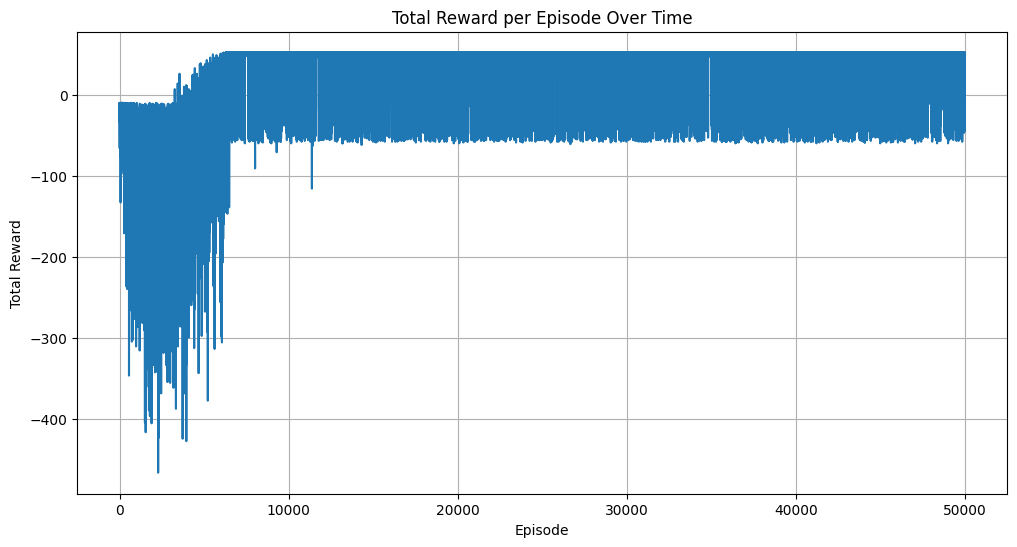

In [9]:
import matplotlib.pyplot as plt

# Plot the total rewards per episode
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode Over Time')
plt.grid(True)
plt.show()


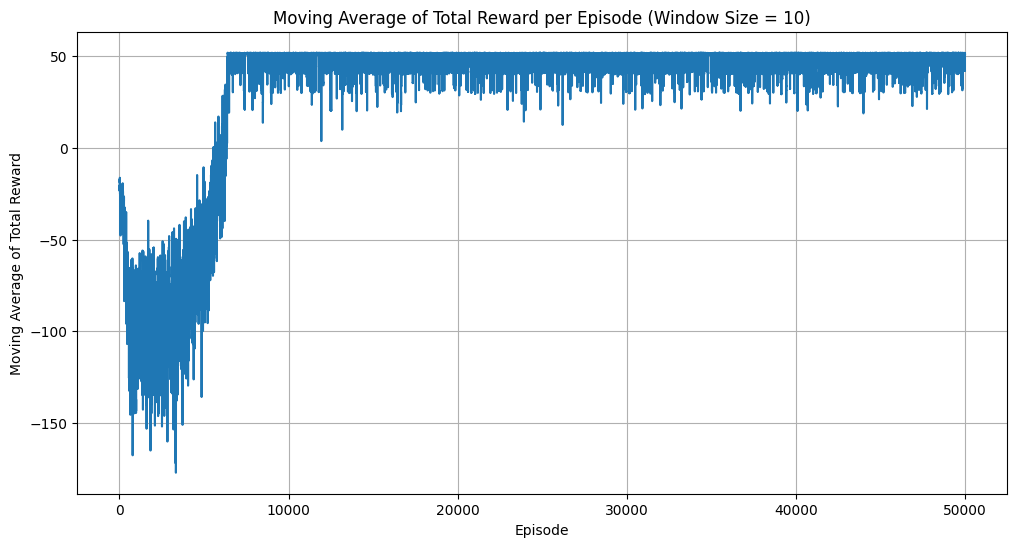

In [10]:

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot the moving average of total rewards
window_size = 10  # You can adjust the window size
moving_avg_rewards = moving_average(total_rewards_per_episode, window_size)

plt.figure(figsize=(12, 6))
plt.plot(range(window_size - 1, episodes), moving_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Moving Average of Total Reward')
plt.title(f'Moving Average of Total Reward per Episode (Window Size = {window_size})')
plt.grid(True)
plt.show()


In [ ]:
state = env.reset()
x, y = state
total_reward = 0
steps = 0

while True:
    env.render()
    time.sleep(0.1)
    action_idx = np.argmax(q_table[x, y, :])
    action = actions[action_idx]
    
    next_state, reward, done = env.step(action)
    x, y = next_state
    total_reward += reward
    steps += 1
    
    if done:
        env.render()
        print(f"Finished after {steps} steps with total reward {total_reward}")
        break
